In [1]:
%matplotlib inline
import numpy as np
from skyfield.api import load
from scipy.optimize import newton
from matplotlib import pyplot as plt
import plotly
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
init_notebook_mode(connected=True)
planets = load('de423.bsp')
plotly.tools.set_credentials_file(username='sevenlin123', api_key='vhjhhsCHepMx5oQGJPEp')

In [2]:
class plutino:
    """
    generate plutinos
    units: au, radius
    
    """
    def __init__(self, size = 1000, mjd = 57023, e_c = 0.175, e_sigma = 0.06, i_sigma = 12,\
                 amp_c = 75, amp_max = 155, amp_min = 0):
        self.size = size
        self.mjd = mjd
        self.lambda_N = None
        self.neptune_lambda()
        self.a = self.gen_a()
        self.e = self.gen_e(e_c, e_sigma)
        self.i = self.gen_i(i_sigma)
        self.amp = self.gen_amp(amp_c, amp_max, amp_min)
        self.phi = self.gen_phi(self.amp)
        self.M = self.gen_M()
        self.node = self.gen_node()
        self.arg = self.gen_arg()
        self.H = self.gen_H()
        cut = (self.e > 0) * (~np.isnan(self.i))
        self.a = self.a[cut]
        self.e = self.e[cut]
        self.i = self.i[cut]
        self.amp = self.amp[cut]
        self.phi = self.phi[cut]
        self.M = self.M[cut]
        self.node = self.node[cut]
        self.arg = self.arg[cut]
        self.H = self.H[cut]
        X, Y, Z, r = zip(*map(self.kep_to_xyz, self.a, self.e, self.i,\
                                                  self.arg, self.node, self.M)) # r**2 = X**2 + Y**2 + Z**2
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.Z = np.array(Z)
        self.r = np.array(r)
        self.xyz_to_equa(self.X, self.Y, self.Z)
        self.H_to_mag()
        
    
    def gen_a(self):
        return 39.45 + np.random.random(self.size) * 0.4 - 0.2
        
    def gen_e(self, e_c, e_sigma):
        return np.random.normal(loc=e_c, scale=e_sigma, size = self.size)
        
    def gen_i(self, i_sigma):
        return np.arcsin(np.random.rayleigh(scale = i_sigma * np.pi/180., size = self.size))
        
    def gen_amp(self, amp_c, amp_max, amp_min):
        return np.random.triangular(amp_min, amp_c, amp_max, size = self.size) * np.pi / 180.
    
    def gen_phi(self, amp):
        return np.pi + amp * np.sin(2*np.pi*np.random.random(self.size)) 
        
    def gen_M(self):
        return 4*np.pi*np.random.random(self.size)
        
    def gen_node(self):
        return 2*np.pi*np.random.random(self.size) % (2*np.pi)
        
    def gen_arg(self):
        return (0.5*self.phi - 1.5*self.M - self.node + self.lambda_N) % (2*np.pi)
        
    def gen_H(self):
        alpha = 0.9
        h0 = 0
        h1 = 10
        h0s10 = 10**(alpha*h0)
        h1s10 = 10**(alpha*h1)
        return np.log10(np.random.random(self.size)*(h1s10-h0s10) + h0s10) / alpha
        
    def H_to_mag(self):
        phase = np.arccos((self.r**2 + self.delta**2 - self.earth_dis**2) / (2 * self.r * self.delta))
        phase_integral = 2/3. * ((1-phase/np.pi)*np.cos(phase) + 1/np.pi*np.sin(phase))
        self.mag_g = self.H + 2.5 * np.log10((self.r**2 * self.delta**2) / phase_integral)
        self.mag_r = self.mag_g - 0.5
        self.mag_i = self.mag_r - 0.5
        self.mag_z = self.mag_i - 0.5
        
    def neptune_lambda(self):
        neptune = planets[8]
        ts = load.timescale()
        t = ts.tai(jd=self.mjd+2400000.500428) #37 leap seconds        
        self.x_n, self.y_n, self.z_n = neptune.at(t).ecliptic_position().au
        self.lambda_N = np.arctan2(self.y_n, self.x_n) % (2*np.pi)

    def kep_to_xyz(self, a, e, i, arg, node, M):
        # compute eccentric anomaly
        f = lambda E, M, e: E - e * np.sin(E) - M
        E0 = M
        E = newton(f, E0, args=(M, e))
        # compute true anomaly
        v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
        # compute the barycentric distance
        r = a * (1 - e*np.cos(E))
        # compute X,Y,Z
        X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
        Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
        Z = r * (np.sin(i) * np.sin(arg + v))
        return X, Y, Z, r
        
    def xyz_to_equa(self, X0, Y0, Z0):
        earth = planets['earth']
        ts = load.timescale()
        t = ts.tai(jd=self.mjd+2400000.500428) #37 leap seconds
        epsilon =  23.43694 * np.pi/180.
        x_earth, y_earth, z_earth = earth.at(t).position.au
        self.earth_dis = (x_earth**2 + y_earth**2 + z_earth**2)**0.5
        X = X0 - x_earth
        Y = Y0 * np.cos(epsilon) - Z0 * np.sin(epsilon)  - y_earth
        Z = Y0 * np.sin(epsilon) + Z0 * np.cos(epsilon) - z_earth
        self.delta = (X**2 + Y**2+ Z**2)**0.5
        self.dec = np.arcsin(Z/(X**2+Y**2+Z**2)**0.5)
        self.ra = np.arctan2(Y, X) % (2*np.pi)

        

In [3]:
p = plutino(size = 2000, mjd=58199, e_c = 0.3, e_sigma = 0.01, amp_c = 1, amp_max = 2, amp_min = 0, i_sigma=12)

(array([ 98., 102.,  84., 116., 109., 106., 102.,  82.,  90., 100., 102.,
        109.,  94., 108.,  93., 105., 103., 101., 117.,  79.]),
 array([39.25047833, 39.27043971, 39.29040109, 39.31036248, 39.33032386,
        39.35028524, 39.37024663, 39.39020801, 39.4101694 , 39.43013078,
        39.45009216, 39.47005355, 39.49001493, 39.50997631, 39.5299377 ,
        39.54989908, 39.56986046, 39.58982185, 39.60978323, 39.62974462,
        39.649706  ]),
 <a list of 20 Patch objects>)

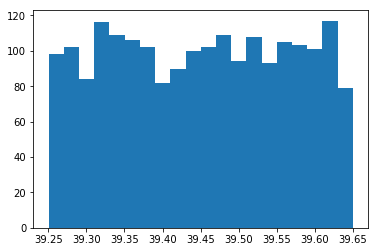

In [4]:
plt.hist(p.a, bins = 20)

(array([  2.,   3.,  16.,  27.,  57.,  93., 142., 165., 250., 260., 263.,
        239., 159., 154.,  69.,  54.,  25.,  15.,   4.,   3.]),
 array([0.26699232, 0.27031576, 0.2736392 , 0.27696264, 0.28028608,
        0.28360952, 0.28693296, 0.29025641, 0.29357985, 0.29690329,
        0.30022673, 0.30355017, 0.30687361, 0.31019705, 0.31352049,
        0.31684393, 0.32016737, 0.32349081, 0.32681426, 0.3301377 ,
        0.33346114]),
 <a list of 20 Patch objects>)

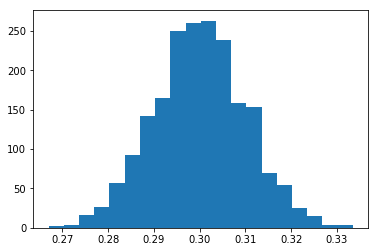

In [5]:
plt.hist(p.e, bins = 20)

(array([ 56., 177., 233., 262., 267., 263., 189., 174., 133.,  90.,  68.,
         41.,  24.,  12.,   5.,   1.,   2.,   1.,   0.,   2.]),
 array([ 0.34562864,  3.18955863,  6.03348861,  8.87741859, 11.72134857,
        14.56527856, 17.40920854, 20.25313852, 23.09706851, 25.94099849,
        28.78492847, 31.62885846, 34.47278844, 37.31671842, 40.16064841,
        43.00457839, 45.84850837, 48.69243836, 51.53636834, 54.38029832,
        57.2242283 ]),
 <a list of 20 Patch objects>)

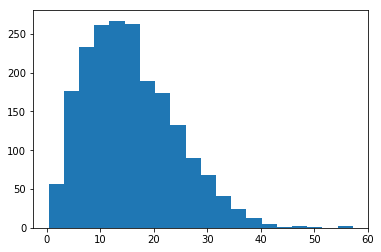

In [6]:
plt.hist(p.i*180/np.pi, bins = 20)

(array([  1.,   0.,   0.,   0.,   1.,   0.,   1.,   1.,   6.,   9.,  10.,
         25.,  25.,  61.,  80., 122., 191., 282., 447., 738.]),
 array([5.65616522, 5.87334679, 6.09052837, 6.30770994, 6.52489152,
        6.7420731 , 6.95925467, 7.17643625, 7.39361782, 7.6107994 ,
        7.82798097, 8.04516255, 8.26234412, 8.4795257 , 8.69670727,
        8.91388885, 9.13107042, 9.348252  , 9.56543358, 9.78261515,
        9.99979673]),
 <a list of 20 Patch objects>)

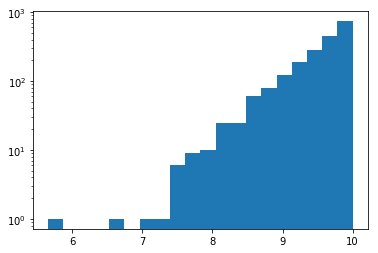

In [7]:
plt.yscale('log')
plt.hist(p.H, bins = 20)

(array([  3.,   1.,   4.,   9.,  11.,  22.,  40.,  58.,  93., 158., 117.,
        107., 114., 127., 170., 153., 225., 250., 225., 113.]),
 array([22.29919225, 22.56468456, 22.83017687, 23.09566918, 23.36116149,
        23.6266538 , 23.89214612, 24.15763843, 24.42313074, 24.68862305,
        24.95411536, 25.21960767, 25.48509998, 25.75059229, 26.0160846 ,
        26.28157691, 26.54706922, 26.81256153, 27.07805384, 27.34354616,
        27.60903847]),
 <a list of 20 Patch objects>)

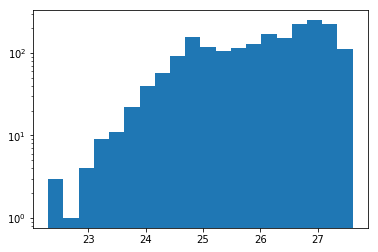

In [8]:
plt.yscale('log')
plt.hist(p.mag_g, bins = 20)

(array([109.,  93., 118.,  97., 100., 109.,  97., 100.,  93.,  97.,  88.,
         88.,  94.,  93., 106.,  93., 101., 111., 105., 108.]),
 array([ 0.01509424,  0.64200688,  1.26891953,  1.89583217,  2.52274482,
         3.14965747,  3.77657011,  4.40348276,  5.03039541,  5.65730805,
         6.2842207 ,  6.91113334,  7.53804599,  8.16495864,  8.79187128,
         9.41878393, 10.04569657, 10.67260922, 11.29952187, 11.92643451,
        12.55334716]),
 <a list of 20 Patch objects>)

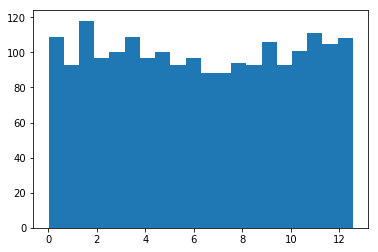

In [9]:
plt.hist(p.M, bins = 20)

(array([ 97.,  92., 111.,  88.,  85.,  96.,  99.,  92.,  99.,  93., 126.,
        100.,  91., 108.,  82., 109., 112., 110.,  98., 112.]),
 array([5.63196831e-03, 3.19418418e-01, 6.33204868e-01, 9.46991318e-01,
        1.26077777e+00, 1.57456422e+00, 1.88835067e+00, 2.20213712e+00,
        2.51592357e+00, 2.82971002e+00, 3.14349647e+00, 3.45728292e+00,
        3.77106937e+00, 4.08485582e+00, 4.39864227e+00, 4.71242872e+00,
        5.02621517e+00, 5.34000162e+00, 5.65378807e+00, 5.96757452e+00,
        6.28136097e+00]),
 <a list of 20 Patch objects>)

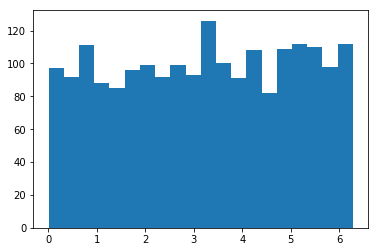

In [10]:
plt.hist(p.arg, bins = 20)

(array([ 96.,  93., 110., 111., 109., 105., 110., 110.,  97.,  74.,  97.,
         90.,  86., 114., 107.,  94., 106., 106.,  97.,  88.]),
 array([2.70325061e-04, 3.13992192e-01, 6.27714059e-01, 9.41435926e-01,
        1.25515779e+00, 1.56887966e+00, 1.88260153e+00, 2.19632339e+00,
        2.51004526e+00, 2.82376713e+00, 3.13748899e+00, 3.45121086e+00,
        3.76493273e+00, 4.07865459e+00, 4.39237646e+00, 4.70609833e+00,
        5.01982019e+00, 5.33354206e+00, 5.64726393e+00, 5.96098580e+00,
        6.27470766e+00]),
 <a list of 20 Patch objects>)

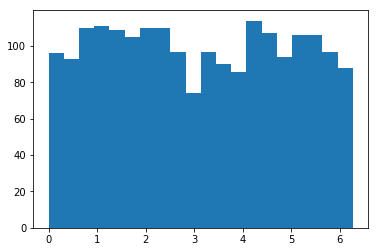

In [11]:
plt.hist(p.node, bins = 20)

(array([104.,  98., 102., 117.,  78.,  98., 110.,  91., 122., 100.,  85.,
         98.,  95., 101., 111.,  98.,  97., 105., 106.,  84.]),
 array([5.54755377e-03, 3.19086369e-01, 6.32625185e-01, 9.46164000e-01,
        1.25970282e+00, 1.57324163e+00, 1.88678045e+00, 2.20031926e+00,
        2.51385808e+00, 2.82739689e+00, 3.14093571e+00, 3.45447452e+00,
        3.76801334e+00, 4.08155215e+00, 4.39509097e+00, 4.70862978e+00,
        5.02216860e+00, 5.33570742e+00, 5.64924623e+00, 5.96278505e+00,
        6.27632386e+00]),
 <a list of 20 Patch objects>)

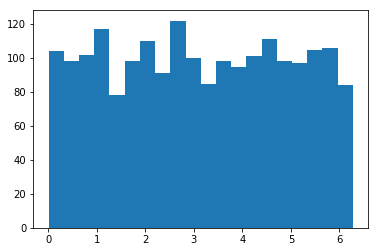

In [12]:
plt.hist((p.arg+p.node) % (2*np.pi), bins = 20)

(array([  5.,  22.,  37.,  54., 104., 119., 155., 163., 174., 160., 180.,
        170., 169., 161., 105., 100.,  56.,  41.,  16.,   9.]),
 array([3.10783738, 3.11123168, 3.11462598, 3.11802028, 3.12141458,
        3.12480888, 3.12820317, 3.13159747, 3.13499177, 3.13838607,
        3.14178037, 3.14517466, 3.14856896, 3.15196326, 3.15535756,
        3.15875186, 3.16214616, 3.16554045, 3.16893475, 3.17232905,
        3.17572335]),
 <a list of 20 Patch objects>)

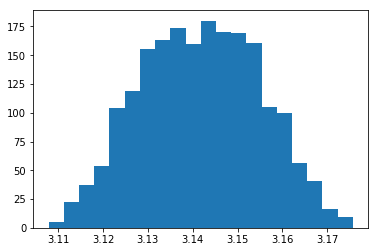

In [13]:
plt.hist(p.phi, bins = 20)

In [14]:
def kep_to_xyz(a, e, i, arg, node, M):
    # compute eccentric anomaly
    f = lambda E, M, e: E - e * np.sin(E) - M
    E0 = M
    E = newton(f, E0, args=(M, e))
    # compute true anomaly
    v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
    # compute the radius
    r = a * (1 - e*np.cos(E))
    # compute X,Y,Z
    X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
    Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
    Z = r * (np.sin(i) * np.sin(arg + v))
    return X, Y, Z

In [15]:
xn, yn, zn = zip(*map(kep_to_xyz, 30+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))
x45, y45, z45 = zip(*map(kep_to_xyz, 45+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))

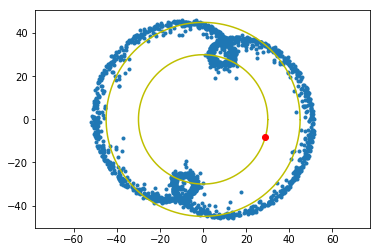

In [16]:
plt.axis('equal')
plt.scatter(p.X,p.Y, marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')
plt.plot(p.x_n, p.y_n, 'ro')

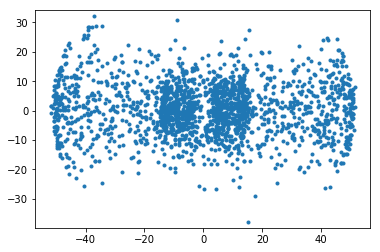

In [17]:
plt.axis('equal')
plt.scatter(p.X,p.Z, marker = '.')

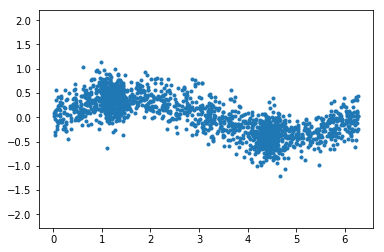

In [18]:
plt.axis('equal')
plt.scatter(p.ra,p.dec, marker = '.')

In [19]:
plutino = Scatter3d(x=p.X, y=p.Y, z=p.Z, mode='markers', marker=dict(size=1, symbol='circle'), opacity=0.7, name='plutinos')
sun = Scatter3d(x=0, y=0, z=0, mode='markers', marker=dict(size=10, symbol='circle'), opacity=1, name='Sun')
neptune = Scatter3d(x=p.x_n, y=p.y_n, z=p.z_n, mode='markers', marker=dict(size=5, symbol='circle'), opacity=0.7, name ='Neptune')
fig = Figure(data=[plutino, sun, neptune])
py.iplot(fig)